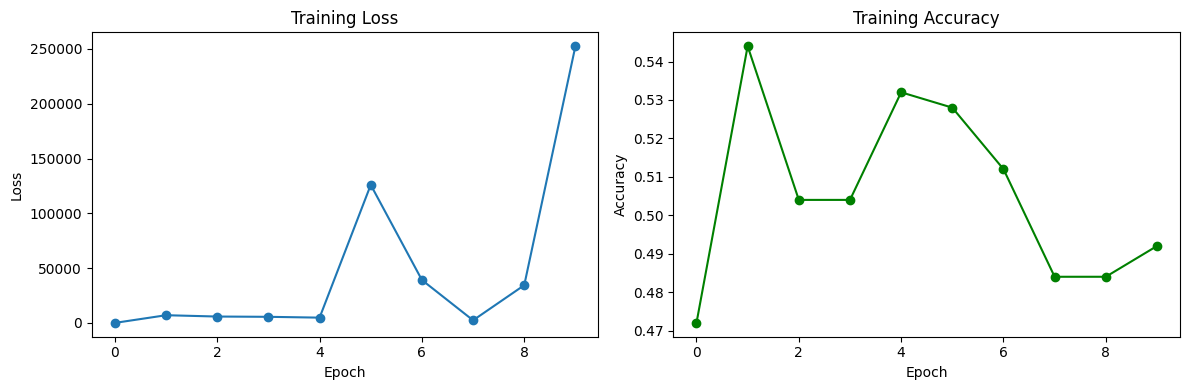

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to create a simple xDeepFM model
def create_xdeepfm_model(input_dim):
    model = tf.keras.Sequential([
        # Your xDeepFM layers go here
        # Example:
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Embedding(input_dim, 10),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

class Client:
    def __init__(self, client_id, local_data):
        self.client_id = client_id
        self.local_data = local_data
        self.model = create_xdeepfm_model(local_data['features'].shape[1])

    def receive_model_parameters(self, global_model):
        self.model.set_weights(global_model)

    def train_local_model(self):
        history = self.model.fit(
            self.local_data['features'], self.local_data['labels'],
            epochs=1, verbose=0
        )
        return history.history['loss'][0], history.history['accuracy'][0]

    def send_updated_parameters(self, epsilon=0.1):
        # Local Differential Privacy (LDP): Introduce Laplace noise
        laplace_noise = [np.random.laplace(0, 1/epsilon, param.shape) for param in self.model.get_weights()]
        noisy_parameters = [w + noise for w, noise in zip(self.model.get_weights(), laplace_noise)]

        return noisy_parameters

# Function for model parameter aggregation (corrected averaging)
def aggregate_parameters(parameter_list):
    # Initialize an empty list to store aggregated weights for each layer
    aggregated_weights = []

    # Iterate through each layer's weights
    for layer_weights in zip(*parameter_list):
        # Calculate the mean for the weights of the current layer
        mean_weights = np.mean(layer_weights, axis=0)
        aggregated_weights.append(mean_weights)

    return aggregated_weights

# Example dataset generation (replace this with loading your actual dataset)
def generate_fake_data(num_clients=10, num_features=20, num_samples=100):
    data = [{'features': np.random.rand(num_samples, num_features), 'labels': np.random.randint(2, size=(num_samples,))}
            for _ in range(num_clients)]
    return data

# Plotting function to visualize training progress
def plot_training_progress(losses, accuracies):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(losses, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, marker='o', color='green')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

# Federated Learning setup
clients = [Client(client_id=i, local_data=local_data) for i, local_data in enumerate(generate_fake_data())]
global_model = create_xdeepfm_model(clients[0].local_data['features'].shape[1])

num_epochs = 10

# Lists to store training progress for visualization
global_losses = []
global_accuracies = []

# Federated training loop
for epoch in range(num_epochs):
    aggregated_parameters = []
    losses = []
    accuracies = []

    # Example: Randomly select half of the clients in each round
    selected_clients = np.random.choice(clients, len(clients)//2, replace=False)

    for client in selected_clients:
        # Step 2: Server sends model parameters to clients
        client.receive_model_parameters(global_model.get_weights())

        # Step 3: Local training on the client
        loss, accuracy = client.train_local_model()

        # Store training progress for visualization
        losses.append(loss)
        accuracies.append(accuracy)

        # Step 4: Client sends back the updated model parameters with LDP
        updated_parameters = client.send_updated_parameters()

        # Accumulate updated parameters for aggregation
        aggregated_parameters.append(updated_parameters)

    # Step 5: Server aggregates the updated parameters
    global_model_weights = aggregate_parameters(aggregated_parameters)
    global_model.set_weights(global_model_weights)

    # Store global training progress for visualization
    global_losses.append(np.mean(losses))
    global_accuracies.append(np.mean(accuracies))

# After training, you can use the global_model for predictions
# For example:
# test_data = generate_fake_data(num_clients=1, num_features=20, num_samples=20)[0]
# predictions = global_model.predict(test_data['features'])

# Visualize training progress
plot_training_progress(global_losses, global_accuracies)
